<div id="container" style="position:relative;">
<div style="float:left"><h1>  Capstone Projects NLP - William Nankap </h1></div>
<div style="position:relative; float:right"><img style="height:65px" src ="https://drive.google.com/uc?export=view&id=1EnB0x-fdqMp6I5iMoEBBEuxB_s7AmE2k" />
</div>
</div>

# NLP ClassifyChat

An innovative text classification project based on natural language processing. It leverages conversations from the freeCodeCamp chat to provide an accurate and efficient solution for automatically categorizing messages and extracting relevant information from large volumes of textual data.

### **`Notebook 3: Countvectorizer + Kmeans + LDA ¶`**

### **`Author: William Nankap`**

Work plan: https://docs.google.com/presentation/d/10xtITocBaQgZYtDw1yWe_FzQPgR7Je6EkNRv8IJVCPM/edit?usp=sharing


-----

# Table of Contents

- ### Introduction
- ### 1. CountVectorization
- ### 2. Data Modeling Kmeans
    - ### First launch
    - ### Hyperparameter optimization
- ### 3. Data Modeling LDA
    - ### First launch
    - ### Hyperparameter optimization
- ### 3. Comparaison
- ### Conclusion

-----

# Introduction

In this next notebook, we will dive into the exciting world of text vectorization and machine learning. Our primary focus will be on applying various techniques to transform our preprocessed text data into numerical representations and leveraging them for machine learning tasks. 

We will explore the CountVectorizer algorithm, which will allow us to convert our text into a matrix of token counts, capturing the frequency of words within each document. Next, we will apply K-means clustering to identify patterns and group similar documents together based on their vectorized representations. 

Additionally, we will delve into Latent Dirichlet Allocation (LDA), a probabilistic topic modeling technique, to uncover latent themes within our text data. Finally, we will train a Support Vector Machine (SVM) classifier, utilizing the vectorized features, to perform text classification or sentiment analysis tasks. 

This notebook promises to be an exciting journey into the realm of text analysis and machine learning. Let's get started!

In [79]:
# We import all the librairies need for exploration, visualization and modeling

import pandas as pd
import numpy as np

#Preprocessing & Tokenization
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.probability import FreqDist

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from gensim.models import Word2Vec as w2v

import string
import re

# plotting
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import seaborn as sns
import pyLDAvis
import pyLDAvis.sklearn

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


from scipy import stats
from statsmodels.stats import multicomp
from scipy.stats import pearsonr
import statsmodels.api as sm

from wordcloud import WordCloud
import time


-----
# 1. Countvectorization

In this part, we will explore the powerful technique of CountVectorizer for text analysis. CountVectorizer is a popular algorithm used for converting text documents into numerical representations that can be understood by machine learning algorithms. 

By creating a matrix of token counts, CountVectorizer allows us to capture the frequency of words in each document of our corpus. This approach enables us to transform unstructured text data into a structured format, enabling the application of various machine learning algorithms. 

Through CountVectorizer, we can gain insights into the importance and occurrence of different words in our text data, paving the way for tasks such as text classification, sentiment analysis, and information retrieval. 

Join us as we uncover the potential of CountVectorizer and harness its capabilities for effective text analysis. Let's dive in!

In [2]:
#Load data
preprocess_clean_freecodecamp_casual = pd.read_csv('preprocess_clean_freecodecamp_casual.csv')

In [4]:
#Checking null value
cs = preprocess_clean_freecodecamp_casual['clean_text'].isna().sum()

print(f'Our dataset contain {cs} null value in our clean_text column.')

Our dataset contain 420407 null value in our clean_text column.


In [5]:
#Cleaning null value
preprocess_clean_freecodecamp_casual = preprocess_clean_freecodecamp_casual.dropna()

These null values are probably due to the fact that there were empty rows in our dataset after the pre-processing process. All we have to do is delete them and move on.

## Vectorization 

As we have over 5 million data records, which is too much for our machine's capacity, we'll use a reduced set of our dataset for our work. Our sample will be around `4% of our dataset`.

### Sample

In [42]:
#Our sample
X_train = preprocess_clean_freecodecamp_casual['clean_text'].sample(frac=0.04, random_state=42)
print(f'Our sample contain {X_train.shape[0]} rows.')

Our sample contain 183413 rows.


# How our words are distributed in this sample?

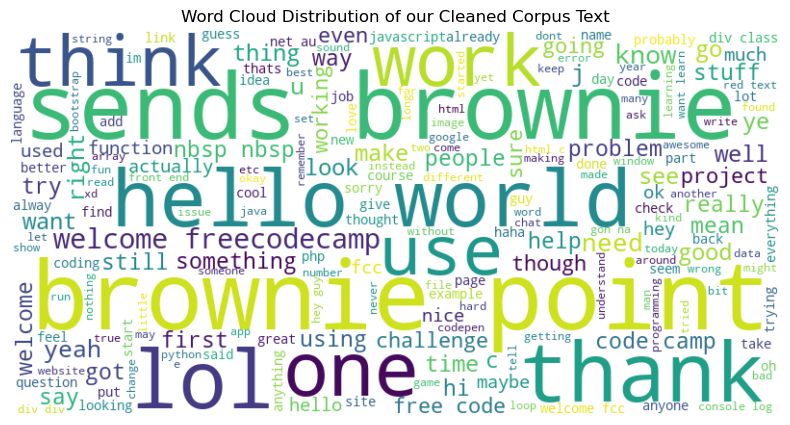

In [21]:
# Combine all the text data into a single string
combined_text = ' '.join(X_train)

# Create the Word Cloud object
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(combined_text)

# Display the Word Cloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud Distribution of our Cleaned Corpus Text')
plt.axis('off')
plt.show()

This visual allows us to see the most frequent words in our dataset before vectorization.

We have a word that occurs 2 times, like `brownie`, and some important words like `point, freecodecamp, code, hello, world...`

When we look online, some comibination have a signification like:
- `brownie point:` This refer some gift exchange by user
- `hello world:` This refer to a common message you can see when you built you first code

We will go throw the vectorization to have more detail and try to see some pattern.

### CountVectorizer

In [56]:
# def calculer_frequence_mots(dataset):
#     # Tokenisation des mots dans le dataset
#     mots = word_tokenize(dataset)

#     # Calcul de la fréquence des mots
#     freq_dist = FreqDist(mots)

#     return freq_dist

# 1. Instantiate 
bagofwords = CountVectorizer(stop_words="english")

# 2. Fit 
bagofwords.fit(X_train)

# 3. Transform
small_transformed = bagofwords.transform(X_train)
small_transformed

<183413x43162 sparse matrix of type '<class 'numpy.int64'>'
	with 763229 stored elements in Compressed Sparse Row format>

In [24]:
#Quick overview on the matrix
small_transformed.toarray().sum(axis=0)

array([13, 12,  1, ...,  1,  1,  1])

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


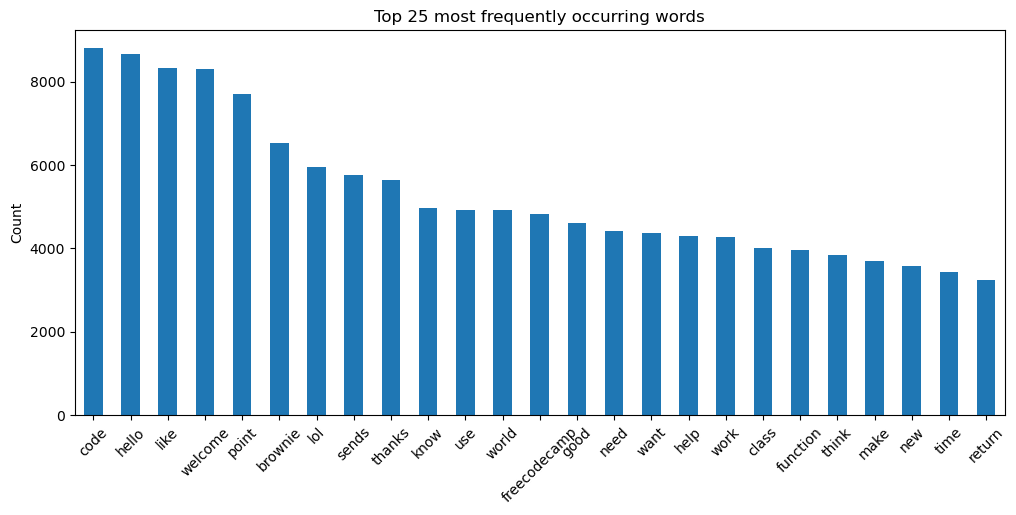

In [95]:
#Overview on the top 25 most frequent word in our corpus text
word_counts = pd.DataFrame(
    {"counts": small_transformed.toarray().sum(axis=0)},
    index=bagofwords.get_feature_names()
).sort_values("counts", ascending=False)

word_counts.head(25).plot(kind="bar", figsize=(12, 5), legend=False)
plt.title("Top 25 most frequently occurring words")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

In [29]:
print(f'Our corpus text contain {word_counts.shape[0]} different words.')

Our corpus text contain 43162 different words.


Looking at the 25 most frequent words in your countvectorizer, here are a few observations:

- The words "brownie" and "point" seem to be specific to your domain or dataset. They could be relevant words for our analysis.

- The words "lol", "thanks", "know", "help", "work", "think" and "make" indicate some social interaction or request for help in our text corpus.

- Certain words such as "freecodecamp", "class" and "function" seem to be linked to programming or code learning concepts, confirming that in our text corpus, discussions around programming were frequent.

## Hyperoptimization of the Countvectorizer

We will try different parameter on our Countvectorizer and see the new distribution, then we will try modeling.

In [59]:
def optimize_countvectorizer(X_train, stop_words=None, max_features=None, min_df=1, max_df=1000):
    """
    Optimize CountVectorizer with different parameters and display the different distributions.

    Parameters:
    - X_train: Training data for CountVectorizer.
    - stop_words: List of stop words to be used. Default is None.
    - max_features: Maximum number of features to be considered. Default is None.
    - min_df: Minimal frequency
    - max_df: Maximal frequency

    Returns:
    - word_counts: DataFrame containing word counts.

    """
    # Instantiate CountVectorizer with specified parameters
    bagofwords2 = CountVectorizer(stop_words=stop_words, max_features=max_features, min_df=min_df, max_df=max_df)

    # Fit and transform the training data
    transformed2 = bagofwords2.fit_transform(X_train)

    # Create a DataFrame of word counts
    word_counts2 = pd.DataFrame(
        {"counts": transformed2.toarray().sum(axis=0)},
        index=bagofwords2.get_feature_names()
    ).sort_values("counts", ascending=False)

    # Plot the top 25 most frequent words
    word_counts2.head(25).plot(kind="bar", figsize=(15, 5), legend=False)
    plt.title("Top 25 most frequently occurring words")
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.show()

    # Return the word_counts DataFrame
    return word_counts2

In [36]:
# List of parameters to iterate over
stop_words_list = [None, "english"]
max_features_list = [None, 1000, 10000, 20000]
min_df = [5, 10, 20, 50]
max_df = [5, 10, 20, 100]


/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


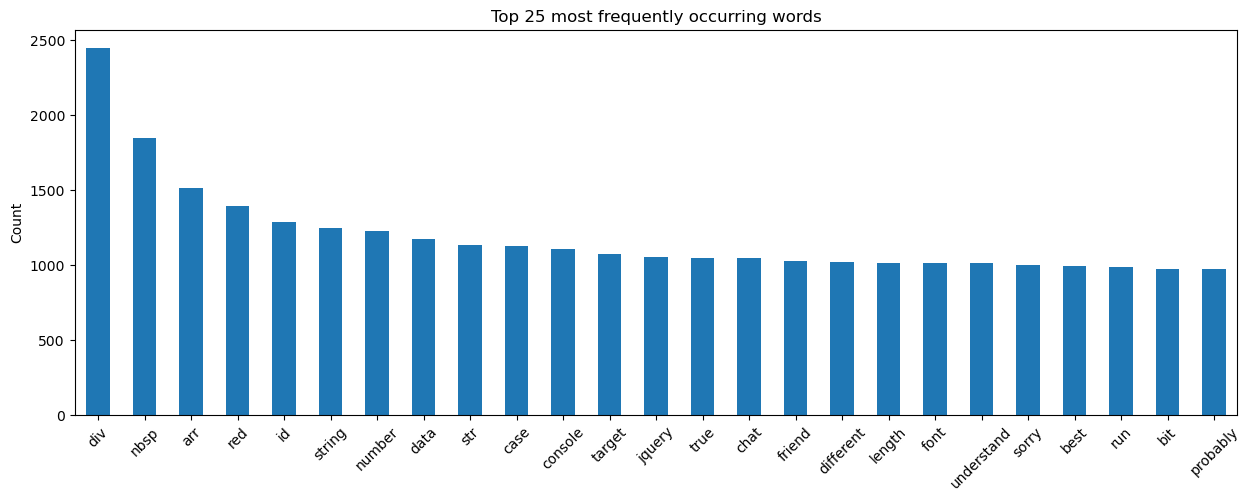

In [60]:
#First test
word_counts2 = optimize_countvectorizer(X_train, stop_words='english', max_features=10000, min_df=5, max_df=1000)

Most of these words don't mean much, but those with a value such as string, number, console, refer to the theme of programming. 

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


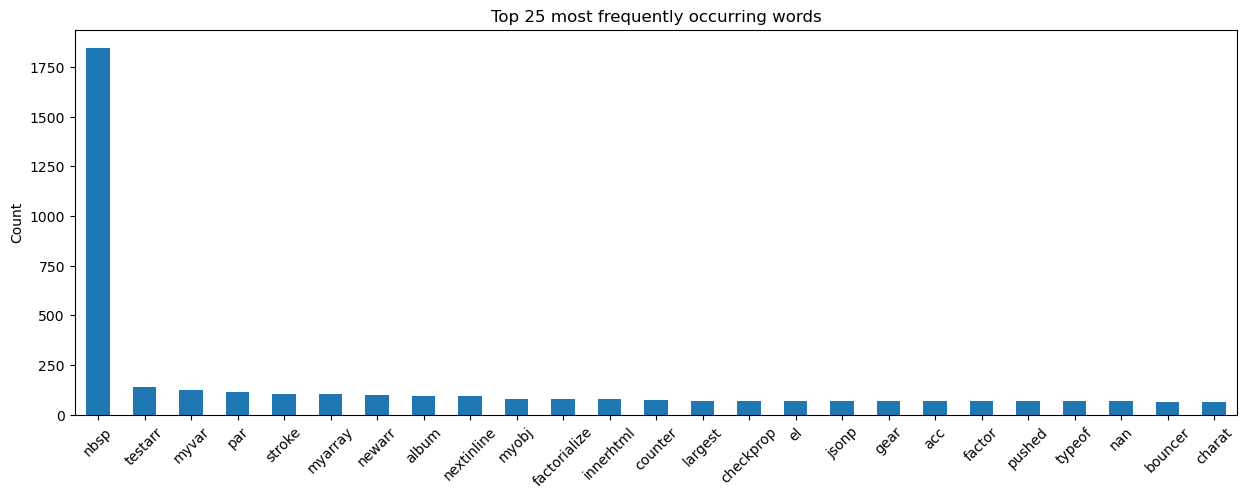

In [61]:
#Second test
word_counts2 = optimize_countvectorizer(X_train, stop_words='english', max_features=1000, min_df=20, max_df=50)

**These words don't mean much.**

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


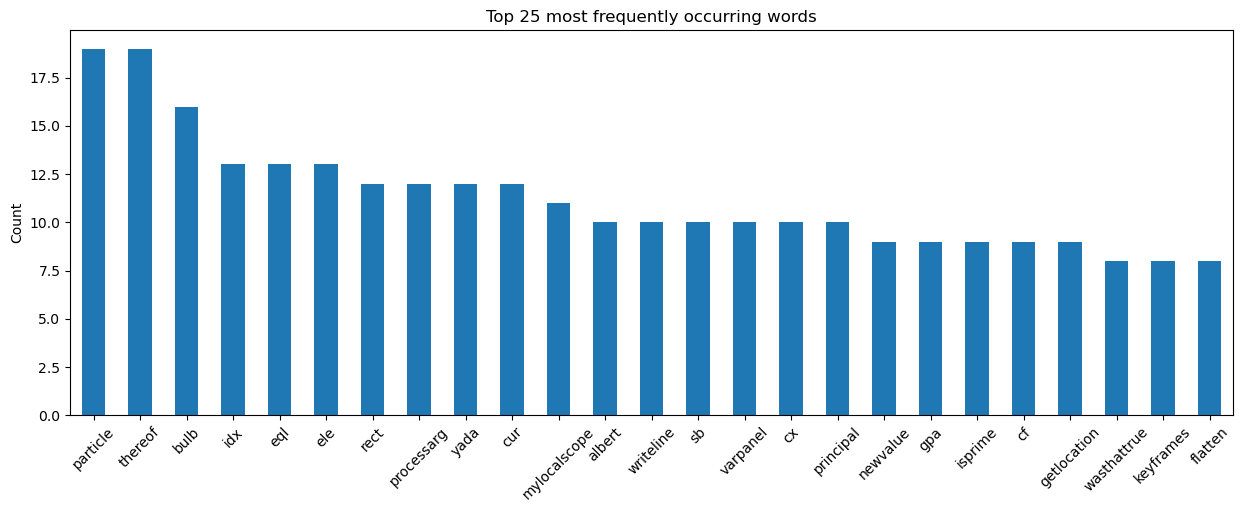

In [62]:
#Third test
word_counts2 = optimize_countvectorizer(X_train, stop_words='english', max_features=1000, min_df=5, max_df=5)

**These words don't mean much.**

For our modeling process, we will continue with our parameter-free vector

# 2. LDA

Latent Dirichlet Allocation (LDA) is a popular topic modeling algorithm used in natural language processing (NLP) to discover hidden topics within a collection of documents. It is an unsupervised learning algorithm that aims to uncover the underlying semantic structure of the text data by assigning topics to each document and word probabilities to each topic.

The LDA algorithm assumes that documents are generated from a mixture of topics, where each topic represents a distribution over words. It then tries to reverse-engineer this process by estimating the topic-word distribution and the document-topic distribution from the observed data.

LDA can be a valuable tool in text analysis, as it allows us to uncover latent themes or topics present in a large corpus of text. It can help in various tasks, such as document clustering, topic summarization, and content recommendation.

In the next step, we will explore how to apply LDA to our text data and extract meaningful topics. We will learn how to preprocess the text, create a document-word matrix, train the LDA model, and interpret the resulting topics. By doing so, we can gain insights into the main themes present in our text data and better understand the underlying patterns and structures within the documents.

In [71]:
#Our lda model function
def model_lda(n_components=10, max_iter=20, learning_method='online'):
    '''
    Function to create and fit an LDA model on the given data.
    
    Parameters:
        - n_components (int): Number of topics to extract. Default is 10.
        - max_iter (int): Number of iterations for topic inference. Default is 20.
        - learning_method (str): Batch learning method. Default is 'online'.
        
    Returns:
        - lda_model: Fitted LDA model object.
    '''
    
    lda_model = LatentDirichletAllocation(n_components=n_components,    # Number of subjects to extract
                                      max_iter=max_iter,        # Number of iterations for topic inference
                                      learning_method=learning_method,  # Batch learning method
                                      random_state=42      # For reproducible results
                                     )
    lda_model.fit(small_transformed)
    
    #Overview on the top 10 subjects in our corpus
    feature_names = bagofwords.get_feature_names()
    for topic_idx, topic in enumerate(lda_model.components_):
        print("Subject %d:" % (topic_idx+1))
        print(" ".join([feature_names[i] for i in topic.argsort()[:-6:-1]]))
        print()
    
    return lda_model

In [72]:
# Start the timer
start_time = time.time()

#Our first LDA Model
lda_model = model_lda(n_components=10, max_iter=20, learning_method='online')

# Calculate the execution time
end_time = time.time()
execution_time = end_time - start_time

print("Execution time: ", execution_time, " seconds")

Subject 1:
need way use start working

Subject 2:
new yes say job using

Subject 3:
hello thanks world good help

Subject 4:
welcome freecodecamp var return hey

Subject 5:
code want know fcc free

Subject 6:
lol function yeah im oh

Subject 7:
class make text cs div

Subject 8:
time learn thank project mean

Subject 9:
like thing guy people look

Subject 10:
point brownie sends use right



/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


When visualizing the topics generated by the LDA model, the following subjects are observed:

- **Subject 1:** This topic seems to be related to the need for finding a way to start working on something.

- **Subject 2:** The topic appears to involve something new and mentioning the word "job."

- **Subject 3:** This topic expresses greetings ("hello"), gratitude ("thanks"), and a general sense of positivity ("world," "good," "help").

- **Subject 4:** The topic revolves around welcoming someone to FreeCodeCamp and mentioning variables and returns.

- **Subject 5:** This topic involves discussing code, expressing a desire to learn ("want"), and mentioning FreeCodeCamp ("fcc").

- **Subject 6:** The topic includes laughter ("lol"), functions, and informal expressions ("im," "oh").

- **Subject 7:** The topic pertains to creating a class, manipulating text, and using CSS ("cs") and div elements.

- **Subject 8:** This topic focuses on the importance of time, learning, gratitude ("thank"), and possibly project-related matters.

- **Subject 9:** The topic discusses personal preferences ("like"), general observations ("thing," "guy," "people"), and the act of looking at something.

- **Subject 10:** This topic involves the concept of earning points ("point") and mentioning "brownie" and "sends." It also touches on the use of something ("use") and possibly determining what is right.



In [67]:
#Enable the librairi for visualization
pyLDAvis.enable_notebook()

In [70]:
#Visualization of the LDA
vis_data = pyLDAvis.sklearn.prepare(lda_model, small_transformed, bagofwords)
pyLDAvis.display(vis_data)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/opt/anaconda3/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(
/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/anaconda3/lib/py

/opt/anaconda3/lib/python3.9/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/opt/anaconda3/lib/python3.9/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/opt/anaconda3/lib/python3.9/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/opt/anaconda3/lib/python3.9/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/opt/anaconda3/lib/python3.9/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__v

- **We have 5 quite different groups of themes, with theme 1 being the furthest removed from the other themes.**
- **The themes `6, 7, 9, 10` are very similar**
- **The other are just close**

This visual also gives us the distribution of the different words in our different themes.

In [74]:
# Start the timer
start_time = time.time()

#Our Second LDA Model
lda_model = model_lda(n_components=20, max_iter=40, learning_method='online')

# Calculate the execution time
end_time = time.time()
execution_time = end_time - start_time

print("Execution time: ", execution_time, " seconds")

Subject 1:
dont line read feel friend

Subject 2:
work people way thank question

Subject 3:
thanks used bootstrap php issue

Subject 4:
code hi free yes camp

Subject 5:
make really ok lot image

Subject 6:
function yeah html oh going

Subject 7:
welcome freecodecamp na add codepen

Subject 8:
use want think learn got

Subject 9:
good var fcc array nbsp

Subject 10:
using check haha user game

Subject 11:
hello world new know job

Subject 12:
lol need time link day

Subject 13:
like class cs div text

Subject 14:
challenge change start end github

Subject 15:
look problem red color actually

Subject 16:
return nice trying test str

Subject 17:
right hey mean number target

Subject 18:
thing try javascript page working

Subject 19:
help say console true log

Subject 20:
point brownie sends guy im

Execution time:  898.9913499355316  seconds


- Topics 1, 2, 4, 6, 9, 13, 15, 16, 17, 18, 19, 20 seem to be related to technical aspects of programming, such as code, functions, use of certain technologies (like Bootstrap and PHP), problems encountered and questions asked.

- Topics 3, 7, 10, 11, 12, 14, are more general and include elements such as acknowledgements, greetings, introductions, links to external resources, changes and challenges.

- Topic 5 seems to focus on creative and visual aspects, with words like "make", "image", and "lot"

# 3. Kmeans

K-means clustering is a popular unsupervised machine learning algorithm used for partitioning data into distinct groups or clusters. It is an iterative algorithm that aims to find the optimal centroids of the clusters by minimizing the within-cluster variance.

In K-means, the number of clusters, denoted as K, is specified in advance. The algorithm starts by randomly selecting K points from the dataset as initial centroids. Then, it assigns each data point to the nearest centroid based on their distance, typically using Euclidean distance. After the assignment, the centroids are recalculated as the mean of the data points within each cluster. This process is repeated iteratively until convergence, where the centroids no longer change significantly or a specified number of iterations is reached.

The resulting clusters represent groups of similar data points, where the similarity is measured by their proximity to the centroids. K-means is widely used for various applications, such as customer segmentation, image compression, anomaly detection, and document clustering.

In this notebook, we will explore the use of K-means clustering as a technique to discover meaningful patterns or structure in our dataset. We will apply the K-means algorithm to our preprocessed data and analyze the resulting clusters to gain insights and make data-driven decisions.

## First, we will try to determine the best parameters for our model.

### Cluster number

In [77]:
# Look over a range of K values
k_range = np.arange(1, 20)

# Instantiate an empty list of inertias
inertia_list = []

# Iterate over ks
for k in k_range:
    
    # Instantiate
    k_means_model = KMeans(n_clusters=k)

    # Fit
    k_means_model.fit(small_transformed)
    
    # Get inertia and add to list
    inertia_list.append(k_means_model.inertia_)

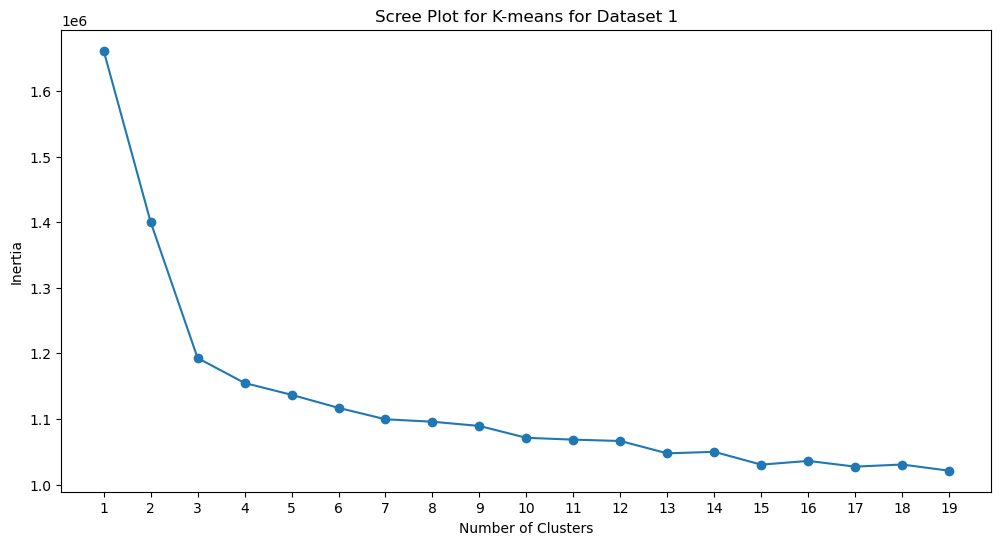

In [81]:
# Visualize our K number of cluster
plt.figure(figsize=(12,6))
plt.plot(k_range, inertia_list, marker="o")
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Scree Plot for K-means for Dataset 1')
plt.xticks(k_range)
plt.show();

**It appears that the elbow point might be around 6 or 7 clusters.**

Let's look the distribution of the silhouette score.

In [83]:
# Look over a range of K values
k_range = np.arange(2, 20)

# Instantiate an empty list of silhouette scores
silhouette_scores = []

# Iterate over ks
for k in k_range:
    
    # Instantiate
    k_means_model = KMeans(n_clusters=k)

    # Fit
    k_means_model.fit(small_transformed)
    
    # Get cluster labels and calculate silhouette score
    cluster_labels = k_means_model.predict(small_transformed)
    silhouette = silhouette_score(small_transformed, cluster_labels)
    
    # Append to list
    silhouette_scores.append(silhouette)

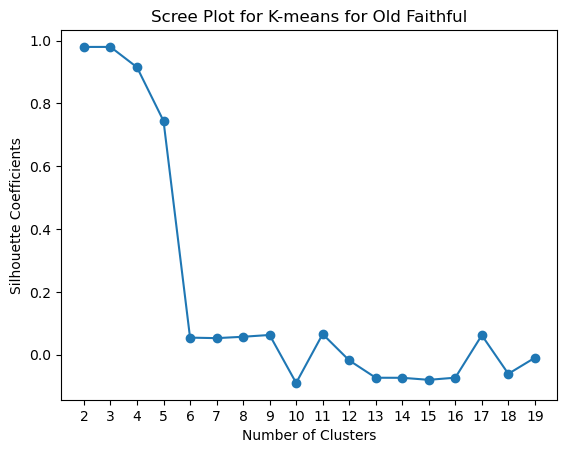

In [84]:
# plot the silhouette 
plt.figure()
plt.plot(k_range, silhouette_scores, marker="o")
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Coefficients')
plt.title('Scree Plot for K-means for Old Faithful')
plt.xticks(k_range)
plt.show();

**It appears that the elbow point might be around 6 or 7 clusters.**


In [90]:
#Our lda model function
def model_kmeans(n_clusters=6, algorithm="elkan"):
    """
    Apply K-means clustering to the given data.

    Parameters:
    - n_components (int): Number of clusters to form.
    - max_iter (int): Maximum number of iterations for the algorithm to converge.
    - learning_method (str): The learning method to use. Possible values are "online" or "batch".

    Returns:
    - cluster_labels (array-like): Labels indicating the cluster membership for each data point.
    """
    
    # Initialize
    kmeans = KMeans(n_clusters=n_clusters, algorithm=algorithm)

    # Fit
    kmeans.fit(small_transformed)

    # Predict
    cluster_labels = kmeans.predict(small_transformed)
    
    print(f'The fit score (inertia) is: {kmeans.inertia_}')
    
    return cluster_labels

In [93]:
mk = model_kmeans(n_clusters=6, algorithm="elkan")

The fit score (inertia) is: 1129332.8374778782


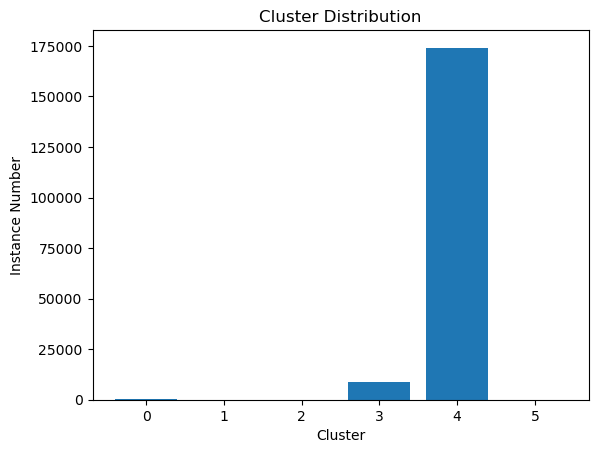

In [94]:
# Count the number of occurrences of each cluster
cluster_counts = np.bincount(mk)

# Create a list of cluster labels
cluster_labels = np.arange(len(cluster_counts))

# Create a bar chart to visualize cluster distribution
plt.bar(cluster_labels, cluster_counts)
plt.xlabel('Cluster')
plt.ylabel('Instance Number')
plt.title('Cluster Distribution')
plt.show()

# Conclusion

In this notebook, we explored the application of CountVectorizer, K-means, and LDA techniques on a text dataset. By analyzing the generated topics, we identified several recurring themes in the discussions.

In this analysis, we uncovered several themes within the discussions. Participants expressed a need for guidance and suggestions in initiating their projects or tasks. Job-related discussions and new opportunities were also prevalent. The community exhibited a positive and supportive atmosphere, with greetings, gratitude, and a focus on learning and improving coding skills. 

Informal humor and discussions about functions added a relaxed tone. Web development, design, and CSS styling were topics of interest. Time management, learning goals, and appreciation for support were emphasized. Participants also shared personal preferences, observations, and perspectives, while discussions around gamification and decision-making processes were present.

By leveraging CountVectorizer, K-means clustering, and LDA, we were able to uncover these themes and gain insights into the content and dynamics of the discussions. These techniques allowed us to explore patterns, group similar topics, and understand the various aspects of the text dataset.